# CV analysis  

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from apstools import s2, xrf
import frgtools.plotting as frgplt
import frgtools.misc as frgm
import mendeleev as men
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from matplotlib import style
mpl.rcParams.update(mpl.rcParamsDefault)
from tqdm import tqdm
import warnings
import seaborn as sns
import h5py as h5
import hdf5plugin
import json
import apstools.s26 as s26
import cmocean
import pickle as pkl
from matplotlib.colors import LogNorm
from matplotlib import colors
from frgtools import curveprocessing
from importlib import reload
import pandas as pd

import matplotlib.colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import os
import numpy as np
import csv
# from .plotting import directionalplot

def getCV(fpath, area =1):
    cvdata = load_cv(fpath)
    cvdata = getOnsetPotentials(cvdata)
    return cvdata

def load_cv(fpath, area = 1):
	# headerkey = {
	#     'Run on channel': 'channel',
	#     'Electrode connection': 'electrode_connection',
	#     'Ewe,I filtering': 'ewe_ifilter',
	#     'Channel': 'channel',
	#     'Acquisition started on': 'datetime',
	#     'Reference electrode': 'ref_electrode',
	# }


	DATA_START = 'mode\tox/red\terror'

	data = {
		'v': None,
		'j': None,
		'numscans': None,
		'area': area,
		'scans': {},
		'header': {}
	}

	key = None
	previouskey = None
	with open(fpath, 'r', errors = 'ignore', encoding = 'utf-8') as f:
		headerlines = 54 #initial guess, will get picked up in code at 
		line = f.readline()#.decode('utf-8')
		while not line.startswith(DATA_START):
			if line.startswith('Acquisition started on'):
				data['date'], data['time'] = line.split(' : ')[1].split(' ')
			else:
				if ' : ' in line:
					key, value = line.split(' : ')
					data['header'][key.strip()] = value.strip()
				elif '  ' in line:
					parts = line.strip().split('  ')
					key = parts[0]
					value = parts[-1]
					if key == 'vs.':
						data['header'][previouskey] += ' vs. {}'.format(value.strip())
					else:
						data['header'][key.strip()] = value.strip()
				previouskey = key
			line = f.readline()#.decode('utf-8')
		
		colnames = []
		for c in line.strip().split('\t'):
			if c == 'ox/red':
				colnames.append(c)
			elif c.startswith('<I>'):
				colnames.append('i')
			elif c.startswith('Ewe'):
				colnames.append('v')
			elif c.startswith('cycle'):
				colnames.append('cycle')
			else:
				colnames.append(c.split('/')[0])
		f_reader = csv.DictReader(f, fieldnames = colnames, delimiter = '\t')  
		data['scans'] = {k:[[]] for k in colnames}
		currentcycle = 1
		for row in f_reader:
			if int(row['cycle']) > currentcycle:
				currentcycle = int(row['cycle'])
				for k in data['scans'].keys():
					data['scans'][k].append([])
			for k, val in row.items():
				data['scans'][k][currentcycle-1].append(float(val))

		data['scans'] = {k:[np.array(cycledata) for cycledata in v] for k,v in data['scans'].items()}
		data['scans']['j'] = [i/area for i in data['scans']['i']]
		data['num_cycles'] = currentcycle
		data['v'] = data['scans']['v'][-1]
		data['j'] = data['scans']['j'][-1]

		return data

def getOnsetPotentials(cvdata,fitwidth = 40):
    # Finding cathodic peak voltage
    X = cvdata['v']
    Y = cvdata['j']
    idx0 = np.argmin(Y)
    cvdata['cathodic_peak'] = X[idx0] 
    
    # Finding anodic peak current at the end of the voltammogram
    idx1 = np.argmax(X)
    cvdata['anodic_peak'] = Y[idx1] 

    # Inflection point onset
    idx2 = np.argmin(X)
    XX = X[idx1+500 : idx2 - 20]
    YY = Y[idx1+500 : idx2 - 20]
    
    dydx = np.gradient(YY)/np.gradient(XX) # Finds first derivative, delta y/ delta x
    dydx = smooth(dydx)
    
    idx3 = np.argmax(dydx) # Inflection point on the cathodic curve
    idx4 = np.argmin(abs(YY)) # Getting closest to the baseline center as possible
    cvdata['inflection_onset'] = XX[idx3]
    
    X_ = XX[idx3 - fitwidth//2: idx3 + fitwidth//2]
    Y_ = YY[idx3 - fitwidth//2: idx3 + fitwidth//2]
    linfit_3 = np.polyfit(X_,Y_,1)
    
    X_ = XX[idx4 - fitwidth//2: idx4 + fitwidth//2]
    Y_ = YY[idx4 - fitwidth//2: idx4 + fitwidth//2]
    linfit_4 = np.polyfit(X_,Y_,1)
    
    intersect_x = (linfit_4[1] - linfit_3[1]) / (linfit_3[0] - linfit_4[1])
    intersect_y = linfit_3[0] * intersect_x + linfit_3[1]
    cvdata['intersect_onset'] = [intersect_x, intersect_y]
    return cvdata

def smooth(a,WSZ=5):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

In [4]:
fids = frgm.listdir('/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/EIS/CV of ETL/T22_txt')

In [5]:
fids

['/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/EIS/CV of ETL/T22_txt/20210720_SnO2-old-0_area_18.6624_02_CV_C01.txt',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/EIS/CV of ETL/T22_txt/20210720_SnO2-recent-1_area_45.9745_02_CV_C01.txt',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/EIS/CV of ETL/T22_txt/20210720_TiO2-pristine-1_area_13.7228_02_CV_C01.txt',
 '/Volumes/GoogleDrive/My Drive/Characterization_RAWDATA/EIS/CV of ETL/T22_txt/20210720_TiO2-scratched-0_area_7.5530_02_CV_C01.txt']

In [8]:
data_1 = getCV(fids[0], area = 18.6624)
data_2 = getCV(fids[1], area = 45.9745)
data_3 = getCV(fids[2], area = 13.7228)
data_4 = getCV(fids[3], area = 7.5530)

In [11]:
data_1['area']

1

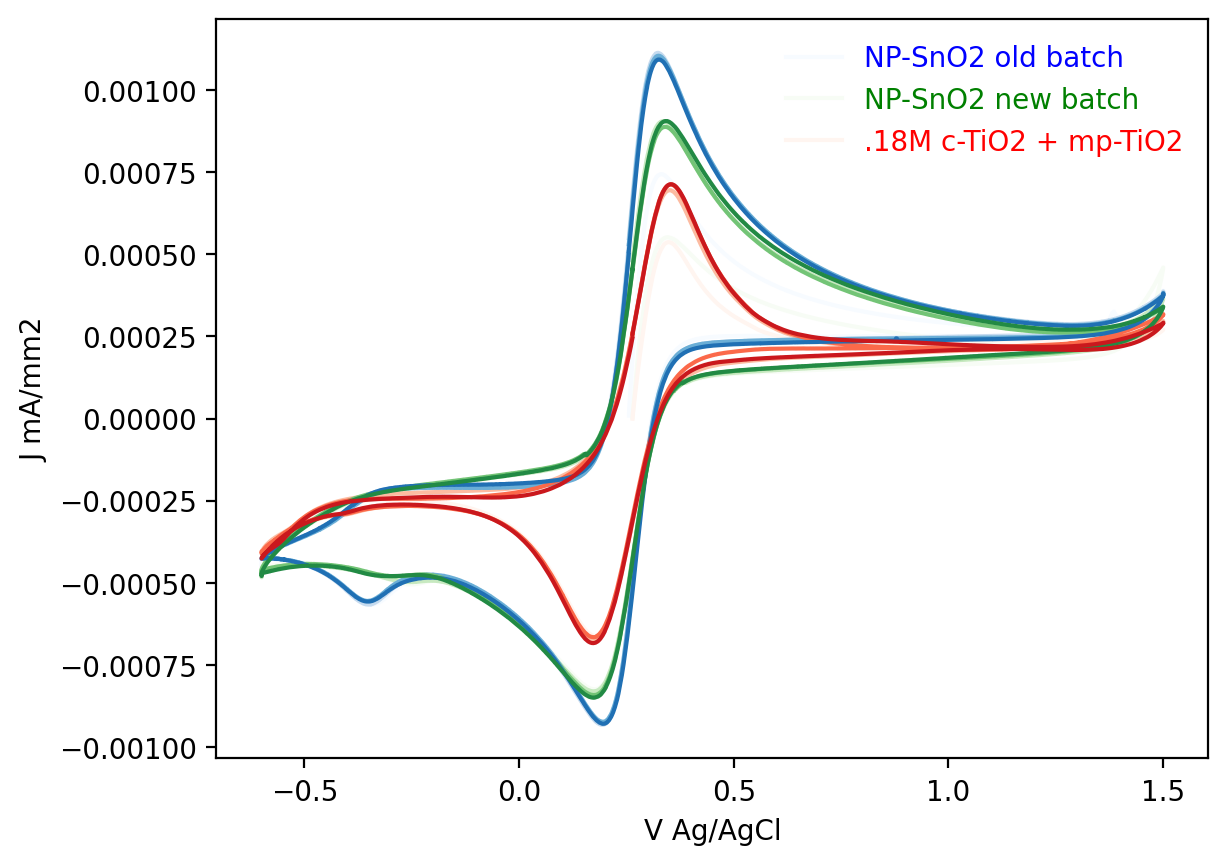

In [51]:
color1 = plt.cm.Blues(np.linspace(0,1,5))
color2 = plt.cm.Greens(np.linspace(0,1,5))
color3 = plt.cm.Reds(np.linspace(0,1,5))
# color4 = plt.cm.viridis(np.linspace(0,1,5))


for n in range(4):
    plt.plot(data_1['scans']['v'][n], data_1['scans']['i'][n]/18.6624, color = color1[n])
    plt.plot(data_2['scans']['v'][n], data_2['scans']['i'][n]/45.9745, color = color2[n])
    plt.plot(data_3['scans']['v'][n], data_3['scans']['i'][n]/13.7228, color = color3[n])
#     plt.plot(data_4['scans']['v'][n], data_4['scans']['i'][n]/7.5530, color = 'lightgreen')


plt.legend(['NP-SnO2 old batch', 'NP-SnO2 new batch', '.18M c-TiO2 + mp-TiO2'], labelcolor=['blue', 'green', 'red'],frameon=False)#, '.18M c-TiO2 TiO2-scratched'])

plt.ylabel('J mA/mm2')
plt.xlabel('V Ag/AgCl')
# plt.legend(frameon=False)

# plt.ylim(-.003, .003)
plt.show()

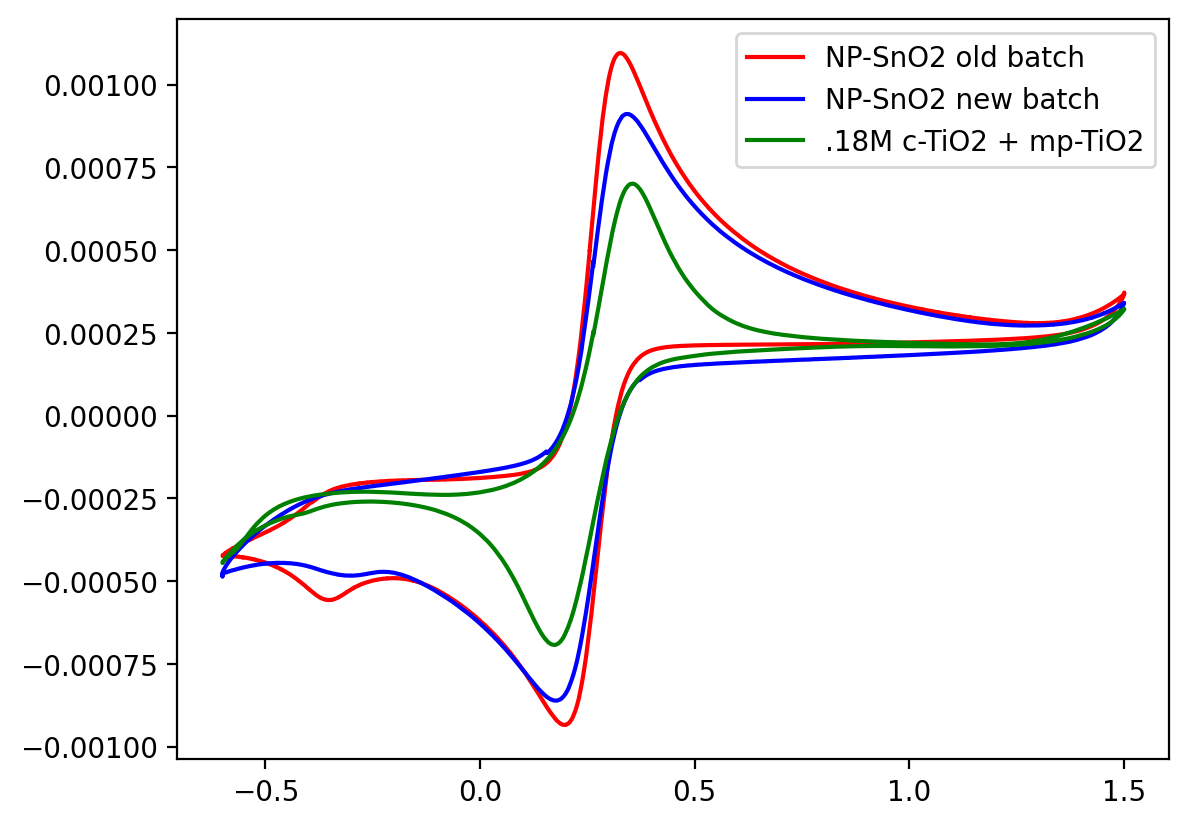

In [43]:
# plt.plot(data_1['v'], data_1['j']/18.6624, color = 'red')
# plt.plot(data_2['v'], data_2['j']/45.9745, color = 'blue')
# plt.plot(data_3['v'], data_3['j']/13.7228, color = 'green')

plt.plot(data_1['scans']['v'][4], data_1['scans']['i'][4]/18.6624, color = 'red')
plt.plot(data_2['scans']['v'][4], data_2['scans']['i'][4]/45.9745, color = 'blue')
plt.plot(data_3['scans']['v'][4], data_3['scans']['i'][4]/13.7228, color = 'green')

plt.legend(['NP-SnO2 old batch', 'NP-SnO2 new batch', '.18M c-TiO2 + mp-TiO2'])#, '.18M c-TiO2 TiO2-scratched'])

plt.show()